# CT3505-24 - Traffic Flows and Management - 2025/26

## Assignment 2: Circular road network with Ramp Metering

## Using this interactive notebook
**Please refer to the course's Brightspace page for a full description of this assignment. Find more information on this notebook in the README.md and INSTALL.md files.**

- Unlike Assignment 1, this notebook is designed to run directly within Visual Studio Code (or your IDE of choice)
- Click on Run All (above) to run the notebook as-is. The notebook is set to run with a "No Control" policy, and with SUMO's Graphical User Interface (GUI) first. You will change these things below, in the code itself.
- Results are visualised below, under "Simulation results".
- You are tasked with implementing your own control logic, below, in the designated area.
- An "on-off" controller is also included, for you to observe how a simple control logic can be implemented and to compare with the "No Control" scenario.

In [1]:
# Imports cell
from random import randint, seed
from dotenv import load_dotenv
import sys, pickle, shutil, os.path
from tud_sumo.simulation import Simulation
from tud_sumo.plot import Plotter, MultiPlotter
from datetime import datetime
import pandas as pd
from lxml import etree

In [2]:
# Convenience functions
import re
def readSimDescription(filename=""):
    description=""
    if filename != "" and filename.split('.')[-1]=='txt' and os.path.exists(filename): #some nice checking that this is a text file with desired outputs
        raw_data=""
        with open(filename,'r') as f:
            raw_data = f.read().replace('\n', '')
        try: #this bit is try catch'd, if it fails description remains = ""
            raw_data=raw_data.split("Description:")[1]
            raw_data=raw_data.split("*")[0]
            raw_data=re.sub('\s{2,}', ' ', raw_data)    
            raw_data=raw_data.replace('|',' ')
            description=raw_data
        except Exception:
            pass
                

    return description

In [3]:
#Simulation backend
simComplete=False
savesDir="./experiments/"
cacheDir="./cache/",
old_sim = None
forceGUI=True #Set to True to always run with GUI, False to run without visuals

trackedEdges=["B999B1000.24","B999B1000.24.27","B999B1000.327","B999B1000"] 

def no_control():
    """
    No control policy - always allow full inflow
    """
    capacity = 2000
    return capacity

def on_off_alg(density):
    """
    Simple on-off control policy:
    Given known values for the critical density of the motorway, and the capacity (saturation flow) of the onramp:
      - if the density on the motorway is above the target, reduce inflow to 0
      - if the density on the motorway is below the target, allow full inflow
    """

    target_density, capacity = 30, 2000
    min_rate, max_rate = 50, 2000
    if density > target_density:
        target_flow = 0
    else:
        target_flow = capacity
        
    # Check max and min
    target_flow = max(min(target_flow, max_rate), min_rate)

    return target_flow

def your_control():
    """
    Your custom control policy goes here.
    Implement your own control policy here, using the on_off_alg and alinea_alg functions above as examples.
    You can add additional parameters to the function definition, if you need to pass in more data.
    For example, you might want to pass in previous metering rate, or data from one or more detectors.
    """
    # YOUR CODE HERE
    pass

def runScenario(my_sim):

    # Start the simulation, defining the sumo config files. Add "-gui" to the command line to run with the GUI.
    my_sim.start("./Network/rm_circle.sumocfg", get_individual_vehicle_data=False, gui=("-gui" in sys.argv) or forceGUI,
                 seed=sim_seed, units="metric", suppress_pbar=True) # Units can either be metric (km,kmph)/imperial (mi,mph)/UK (km,mph). All data collected is in these units.
    
    my_sim.add_tracked_edges(trackedEdges)

    my_sim.add_tracked_junctions({"ramp_meter":
                                {'meter_params':
                                    {'min_rate': 0,  # Minimum allowed metering rate
                                    'max_rate': 2000,  # Maximum allowed metering rate
                                    'init_rate': 2000, # Initial metering rate
                                    },
                                'flow_params':
                                    {'inflow_detectors': ["ramp_inflow", "ramp_upstream"],
                                    'outflow_detectors': ["ramp_downstream"]}
                                }
                            })

    n, sim_dur, warmup = 1, ((40*60) / my_sim.step_length), 15 / my_sim.step_length
    
   
    if warmup > 0:
        my_sim.step_through(n_steps=warmup, pbar_max_steps=sim_dur+warmup, keep_data=False)
    
    old_rate = 2000 #Initial metering rate

    while my_sim.curr_step < sim_dur + warmup and my_sim.is_running():

        #Set the ramp metering rate (vehicles per hour)
        if my_sim.curr_step % 15 == 0 and my_sim.curr_step >= 60: #Update control every 15 seconds, start controlling after 60 seconds

            avg_us_density = my_sim.get_interval_detector_data("ramp_upstream", "density", 15)
            new_rate = no_control()
            #new_rate = on_off_alg(avg_us_density) # Uncomment this line to use the on-off controller
            #new_rate = your_control() # Uncomment this line to use your custom controller

            old_rate=new_rate
            my_sim.set_tl_metering_rate(rm_id="ramp_meter", metering_rate=new_rate, control_interval=15, vehs_per_cycle=3)

        # Step through n seconds.
        my_sim.step_through(n_seconds=n, pbar_max_steps=sim_dur+warmup)
        



    # End the simulation.
    my_sim.end()


scenario_name="circle_"+datetime.now().strftime("%Y-%m-%d %H:%M:%S")
scenario_savefile=savesDir+"circle_"+datetime.now().strftime("%Y-%m-%d %H:%M:%S")




if not simComplete:
    print(f'Simulating scenario...')
    # Initialise the simulation object.
    scenario_desc = f"Circular roadway with Ramp Metering. "+datetime.now().strftime("%Y-%m-%d %H:%M:%S") #Procedurally generated scenario description for later readability
    my_sim = Simulation(scenario_name, scenario_desc=scenario_desc)
    # Add "-seed {x}" to the command line to set a seed for the simulation
    sim_seed = "1" if "-seed" not in sys.argv[:-1] else sys.argv[sys.argv.index("-seed")+1]
    seed(int(sim_seed))
    try:
        runScenario(my_sim)
    except Exception as e:
        print("Scenario computation failed. Error detail:", e)
        pass #Simply discard this simulation
    
    simComplete=True
    
        
    

Simulating scenario...
 Retrying in 1 seconds



(step 1886) (WARNING) Simulation.is_running(): Ended simulation early (no vehicles remaining).


# Simulation results

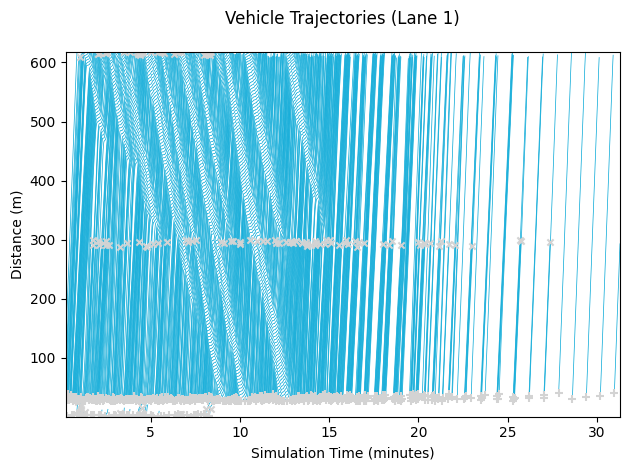

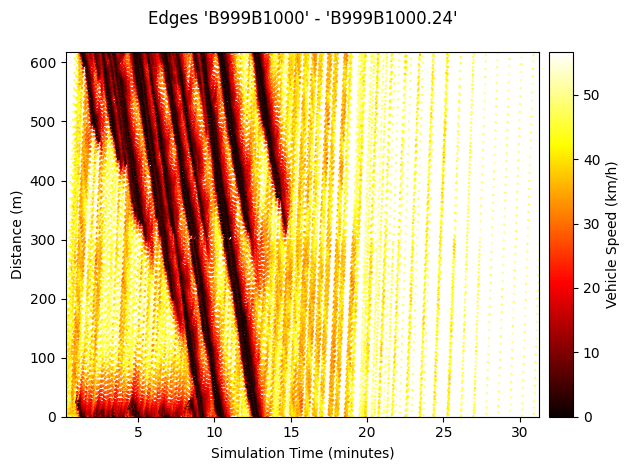

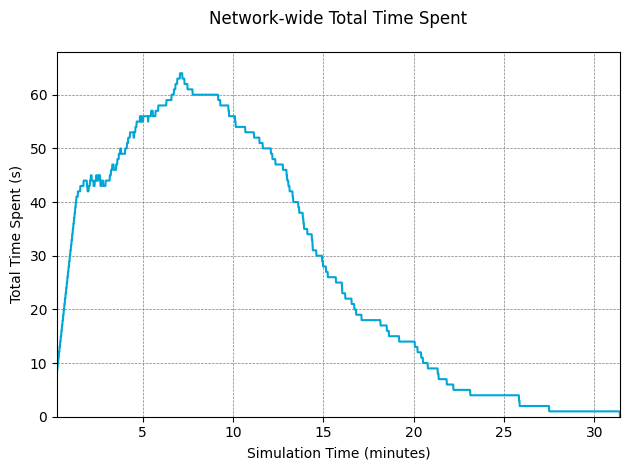

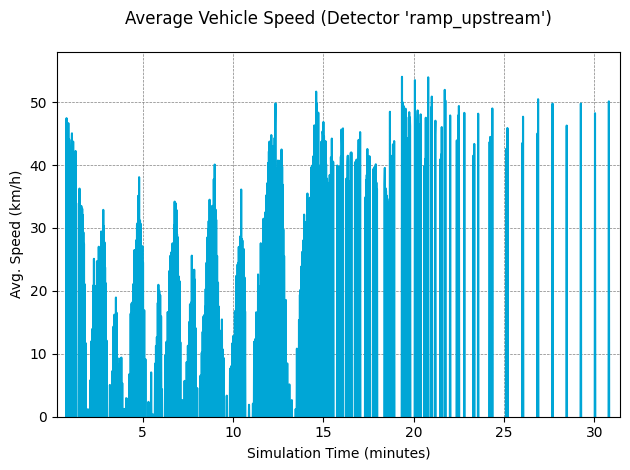

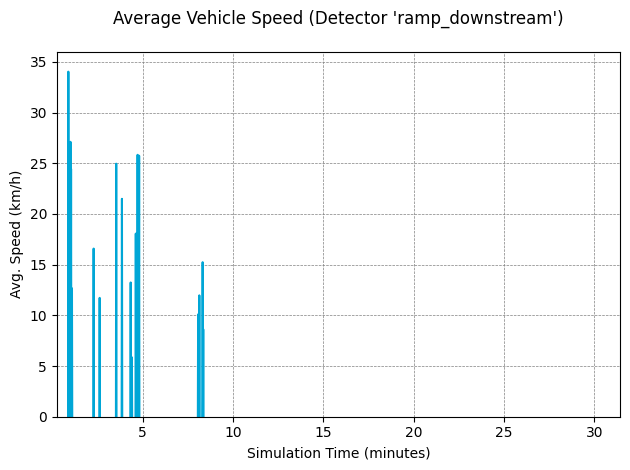

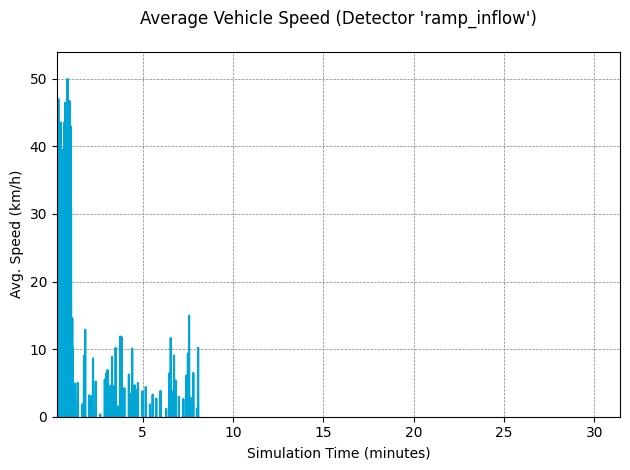

In [4]:
# Visualisation cells: show relevant sim results directly from my_sim object


if simComplete:
    plt = Plotter(my_sim,time_unit="minutes")
    plt.plot_trajectories(trackedEdges, lane_idx=0)
    plt.plot_space_time_diagram(trackedEdges)
    plt.plot_vehicle_data("tts")
    plt.plot_detector_data("ramp_upstream", "speeds")
    plt.plot_detector_data("ramp_downstream", "speeds")
    plt.plot_detector_data("ramp_inflow", "speeds")

    
    # for edge in trackedEdges:
    #     plt.plot_edge_data(edge,"speeds")
    #     plt.plot_edge_data(edge,"densities")
    #     plt.plot_edge_data(edge,"flows")